# BE Hawkes

## Importation des librairies

In [10]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style()

from ipywidgets import interact
import ipywidgets as widgets

## Algorithmes de simulation

In [11]:
def Simulate_HPP(lamb, T):
    n = 0
    t = [- np.log(npr.random()) / lamb]
    while t[-1] <= T:
        u = npr.random()
        w = - np.log(u) / lamb
        t.append(t[-1] + w)
    return t

In [12]:
def Simulate_IPP(lamb, T, lamb_bar):
    n = 0
    m = 0
    t = []
    s = 0
    
    while s < T:
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        if D < lamb(s)/lamb_bar:
            t.append(s)
    if t[-1] < T:
        return t
    else:
        return t[:-1]
        
        

In [30]:
def Simulate_Hawkes(mu, alpha, beta, T):
    tau = []
    s = 0
    while s < T:
        lamb_bar = mu + sum([alpha * np.exp(- beta * (s - t)) for t in tau])
        u = npr.random()
        w = -np.log(u)/lamb_bar
        s += w
        D = npr.random()
        
        if D * lamb_bar < mu + sum([alpha * np.exp(- beta * (s - t)) for t in tau]):
            tau.append(s)
        
    if tau[-1] < T:
        return tau
    else:
        return tau[:-1]
    
def lamb_Hawkes(t, tau, mu, alpha, beta):
    tau_inf = np.asarray(tau)[np.where(np.asarray(tau) < t)]
    return mu + sum([alpha * np.exp(- beta * (t - Tau)) for Tau in tau_inf])

## Fonctions d'affichage

In [14]:
def plot_PP(t):
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.step([0] + t, [0] + list(range(len(t))))
    plt.scatter(t,[0]*len(t),color='r')
    for h, T in enumerate(t):
        plt.plot([T, T], [0, h], '--', color="darkred")
    ax.set_xlabel("t",fontsize=20)
    ax.set_ylabel("N(t)",fontsize=20)
    plt.show()

In [15]:
def plot_Hawkes(mu, alpha, beta, T):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True, gridspec_kw = {'height_ratios':[2, 1]})
    tau = Simulate_Hawkes(mu, alpha, beta, T)
    ax[0].step([0] + tau, [0] + list(range(len(tau))))
    ax[0].scatter(tau , [0] * len(tau), color='r')
    for h, Tau in enumerate(tau):
        ax[0].plot([Tau, Tau], [0, h], '--', color="darkred")
    
    tt = np.linspace(0, T, num=10000)
    lamb_to_plot = [lamb_Hawkes(t, tau, mu, alpha, beta) for t in tt]
    
    ax[1].plot(tt, lamb_to_plot)
    ax[1].scatter(tau,[0]*len(tau),color='r')
    for h, Tau in enumerate(tau):
        ax[1].plot([Tau, Tau], [0, lamb_Hawkes(Tau, tau, mu, alpha, beta)], '--', color="darkred")
    
    
    ax[1].set_xlabel("t",fontsize=20)
    ax[0].set_ylabel("N(t)",fontsize=20)
    ax[1].set_ylabel("$\lambda$(t)",fontsize=20)
    
    ax[0].set_title("Processus de Hawkes, " + r"$\mu =$"  + str(mu) +  r"$, \alpha =$" + str(alpha) + r"$, \beta =$" + str(beta), fontsize=20)
    plt.show()

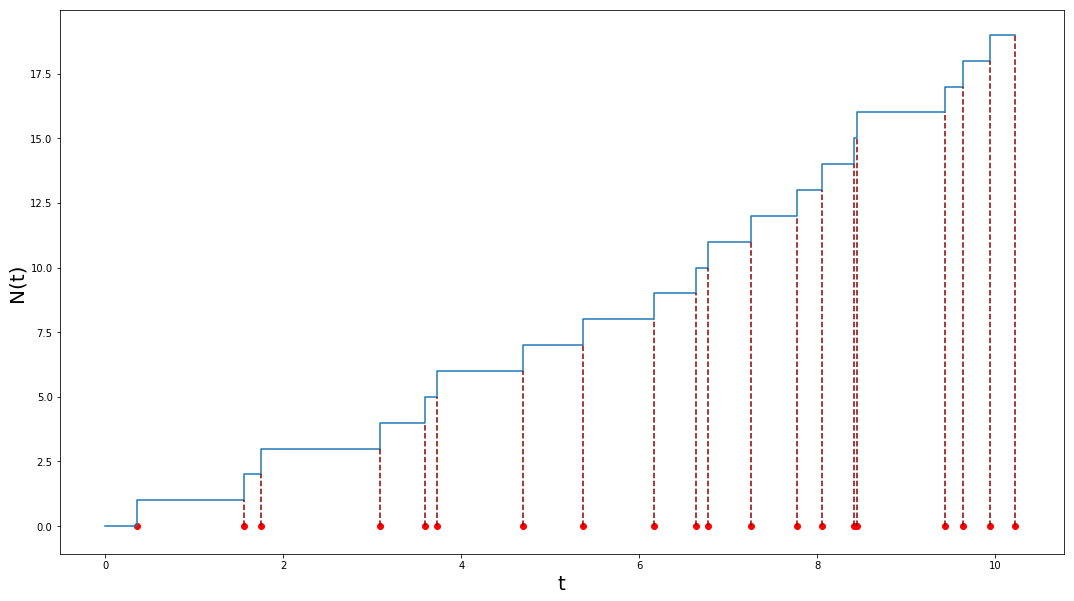

In [16]:
#HPP
plot_PP(Simulate_HPP(3, 10))

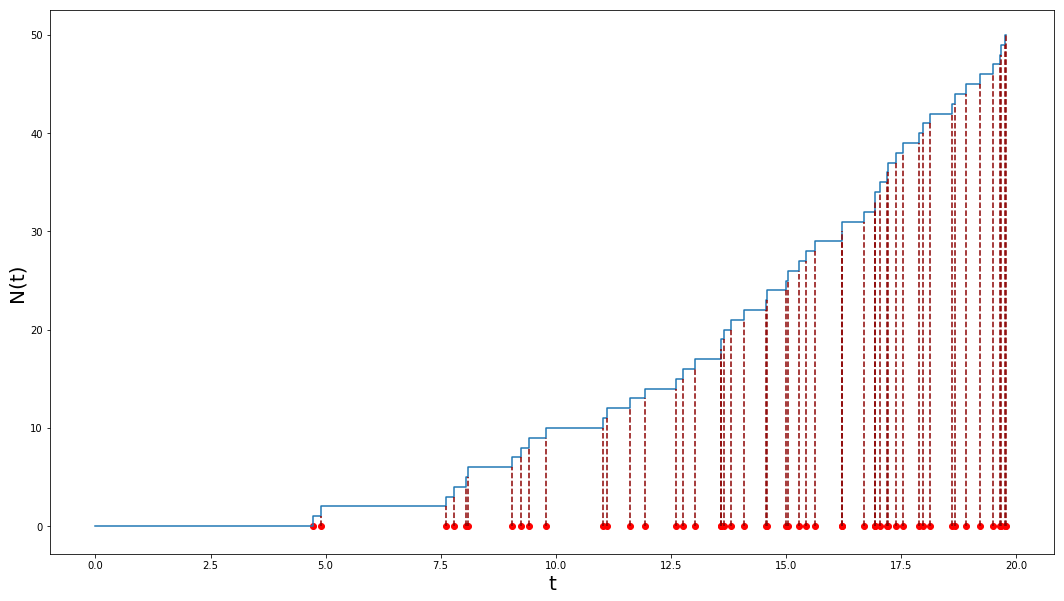

In [17]:
#IPP
def lamb0(t):
    return t/4
plot_PP(Simulate_IPP(lamb0,20,5))

In [26]:
mu = 1.2
alpha = 0.6
beta = 0.8
T=15

@interact(alpha=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.6, continuous_update=False),beta=widgets.FloatSlider(min=0, max=3, step=0.1, value=0.8, continuous_update=False))
def test_param(alpha, beta):
    if alpha < beta:
        plot_Hawkes(mu, alpha, beta, T)
    else:
        print("Alpha doit être inférieur à beta !")

interactive(children=(FloatSlider(value=0.6, continuous_update=False, description='alpha', max=3.0), FloatSlid…

Avec $\alpha = 0$, on retrouve un PP homogène.

Plus $\alpha$ est grand, plus le processus saute souvent.

Plus $\beta$ est grand, plus la décroissance de $\lambda$ est rapide

In [37]:
#import numba

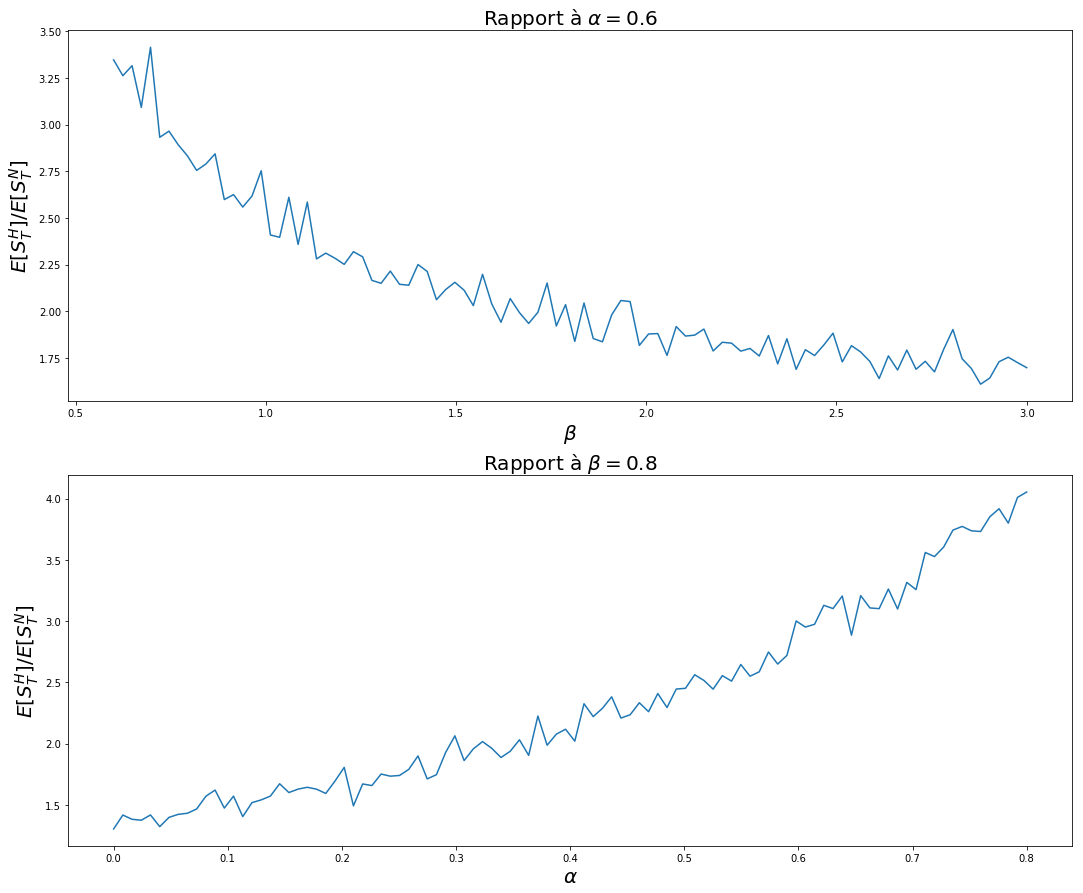

In [49]:
mu = 1.2
sigma = 1
T = 5
alpha = 0.6
beta = 0.8


def ST_Hawkes(mu, sigma, alpha, beta, T):
    N = len(Simulate_Hawkes(mu, alpha, beta, T))
    X = np.exp(npr.normal(mu, sigma, N)) #Loi logNormale
    return sum(X)

def Rapport_ST(mu, sigma, alpha, beta, T):
    nb_beta = 100
    nb_alpha = 100
    range_beta = np.linspace(alpha, 3, nb_beta)
    range_alpha = np.linspace(0, beta, nb_alpha)
    S_beta = np.zeros(nb_beta)
    S_alpha = np.zeros(nb_alpha)
    #@numba.jit()
    for i in range(300):
        S_beta += np.array([ST_Hawkes(mu, sigma, alpha, beta, T) for beta in range_beta])
        S_alpha += np.array([ST_Hawkes(mu, sigma, alpha, beta, T) for alpha in range_alpha])
    S_beta = S_beta / (T * mu ** 2) / 1000
    S_alpha = S_alpha / (T * mu ** 2) / 1000
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 15))
    
    ax[0].plot(range_beta, S_beta)
    ax[0].set_title("Rapport à " + r"$\alpha = $" + str(alpha), fontsize=20)
    ax[0].set_xlabel(r"$\beta$", fontsize=20)
    ax[0].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)

    ax[1].plot(range_alpha, S_alpha)
    ax[1].set_title("Rapport à " + r"$\beta = $" + str(beta), fontsize=20)
    ax[1].set_xlabel(r"$\alpha$", fontsize=20)
    ax[1].set_ylabel(r"$E[S_T^H]/E[S_T^N]$", fontsize=20)
    plt.show()
    
Rapport_ST(mu, sigma, alpha, beta, T)